## Long Short-Term Memory (LSTMs)

In [1]:
# Import all required libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Import feature and target columns
df = pickle.load(open("../../common/pima.p", "rb"))
target_columns = pickle.load(open("../../common/feature_cols.p", "rb"))
split_size = pickle.load(open("../../common/split_size.p", "rb"))
n_past = pickle.load(open("../../common/n_past.p", "rb"))
n_future = pickle.load(open("../../common/n_future.p", "rb"))

### Perform Cross Validation

### Train the model

In [3]:
# Create function to prepare data sequences
def create_sequences(input_data, n_past, n_future, target_column_index):
    X, y = [], []
    for window_start in range(len(input_data) - n_past - n_future + 1):
        past_end = window_start + n_past
        future_end = past_end + n_future
        X.append(input_data[window_start:past_end, :])
        y.append(input_data[past_end:future_end, target_column_index])
    return np.array(X), np.array(y)

In [4]:
def print_score(y_test, y_pred, name):
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    rmse = np.sqrt(mse) # root mean squared error
    r2 = r2_score(y_test_flat, y_pred_flat)

    print(f'{name} Metrics')
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R^2:', r2)
    print('----------------------')

In [5]:
# Initialize a dictionary to store the scalers
scalers = {}

# Scale each target column individually and store the scaler
scaled_df = df[target_columns].copy()
for i, target_col in enumerate(target_columns):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df[target_col] = scaler.fit_transform(df[[target_col]].values)
    scalers[target_col] = scaler

# Convert the DataFrame back to a numpy array
scaled_df = scaled_df.values

# Prepare the training and test sets
train_size = int(len(scaled_df) * split_size)
test_size = len(scaled_df) - train_size
train, test = scaled_df[:train_size, :], scaled_df[train_size:, :]

# Get test statuses data
statuses_df = df[["status"]].copy().values
status_size = train_size + n_past
status_test = statuses_df[status_size:, :].copy()
statuses = status_test[:, -1]

In [6]:
# Train models and make initial predictions
models = {}
initial_predictions = {}
for i, target_col in enumerate(target_columns):
    # Prepare sequences
    X_train, y_train = create_sequences(train, n_past, n_future, i)
    X_test, y_test = create_sequences(test, n_past, n_future, i)

    # Design LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_past, X_train.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(n_future))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    models[target_col] = model

    # Initial prediction
    initial_predictions[target_col] = model.predict(X_test)

14/14 [==============================] - 0s 4ms/step


### Predict the value

In [7]:
# Recursive multi-step forecast
n_steps = len(test) - n_past
predictions = {col: [] for col in target_columns}
for step in range(n_steps):
    current_seq = test[step:step + n_past, :]
    next_seq = current_seq.copy()  # copy of the current sequence to be updated with predictions
    for i, target_col in enumerate(target_columns):
        model = models[target_col]
        pred = model.predict(current_seq.reshape(1, n_past, -1))[0,0]
        predictions[target_col].append(pred)
        next_seq[-1, i] = pred  # update next sequence with the prediction
    current_seq = next_seq  # use the sequence updated with predictions for the next step

1/1 [==============================] - 0s 25ms/step


### Visualize the model

cpu_usage Metrics
MAE: 0.04524970926760502
MSE: 0.003316440637042393
RMSE: 0.05758854605772222
R^2: 0.5458753247992245
----------------------
memory_usage Metrics
MAE: 0.00128553773265964
MSE: 4.326100894406702e-06
RMSE: 0.002079928098374245
R^2: 0.585616019764762
----------------------
bandwidth_inbound Metrics
MAE: 2517.963990467
MSE: 10512992.42701937
RMSE: 3242.3745044364277
R^2: 0.2940676578512924
----------------------
bandwidth_outbound Metrics
MAE: 2101.86448911271
MSE: 7148956.254142071
RMSE: 2673.753214891395
R^2: 0.3387865927287057
----------------------
tps Metrics
MAE: 0.062418402703303205
MSE: 0.01049290185564496
RMSE: 0.10243486640614591
R^2: 0.9839602559355386
----------------------
response_time Metrics
MAE: 73.58148697187316
MSE: 14366.553022125767
RMSE: 119.86055657356913
R^2: 0.9772802314343207
----------------------


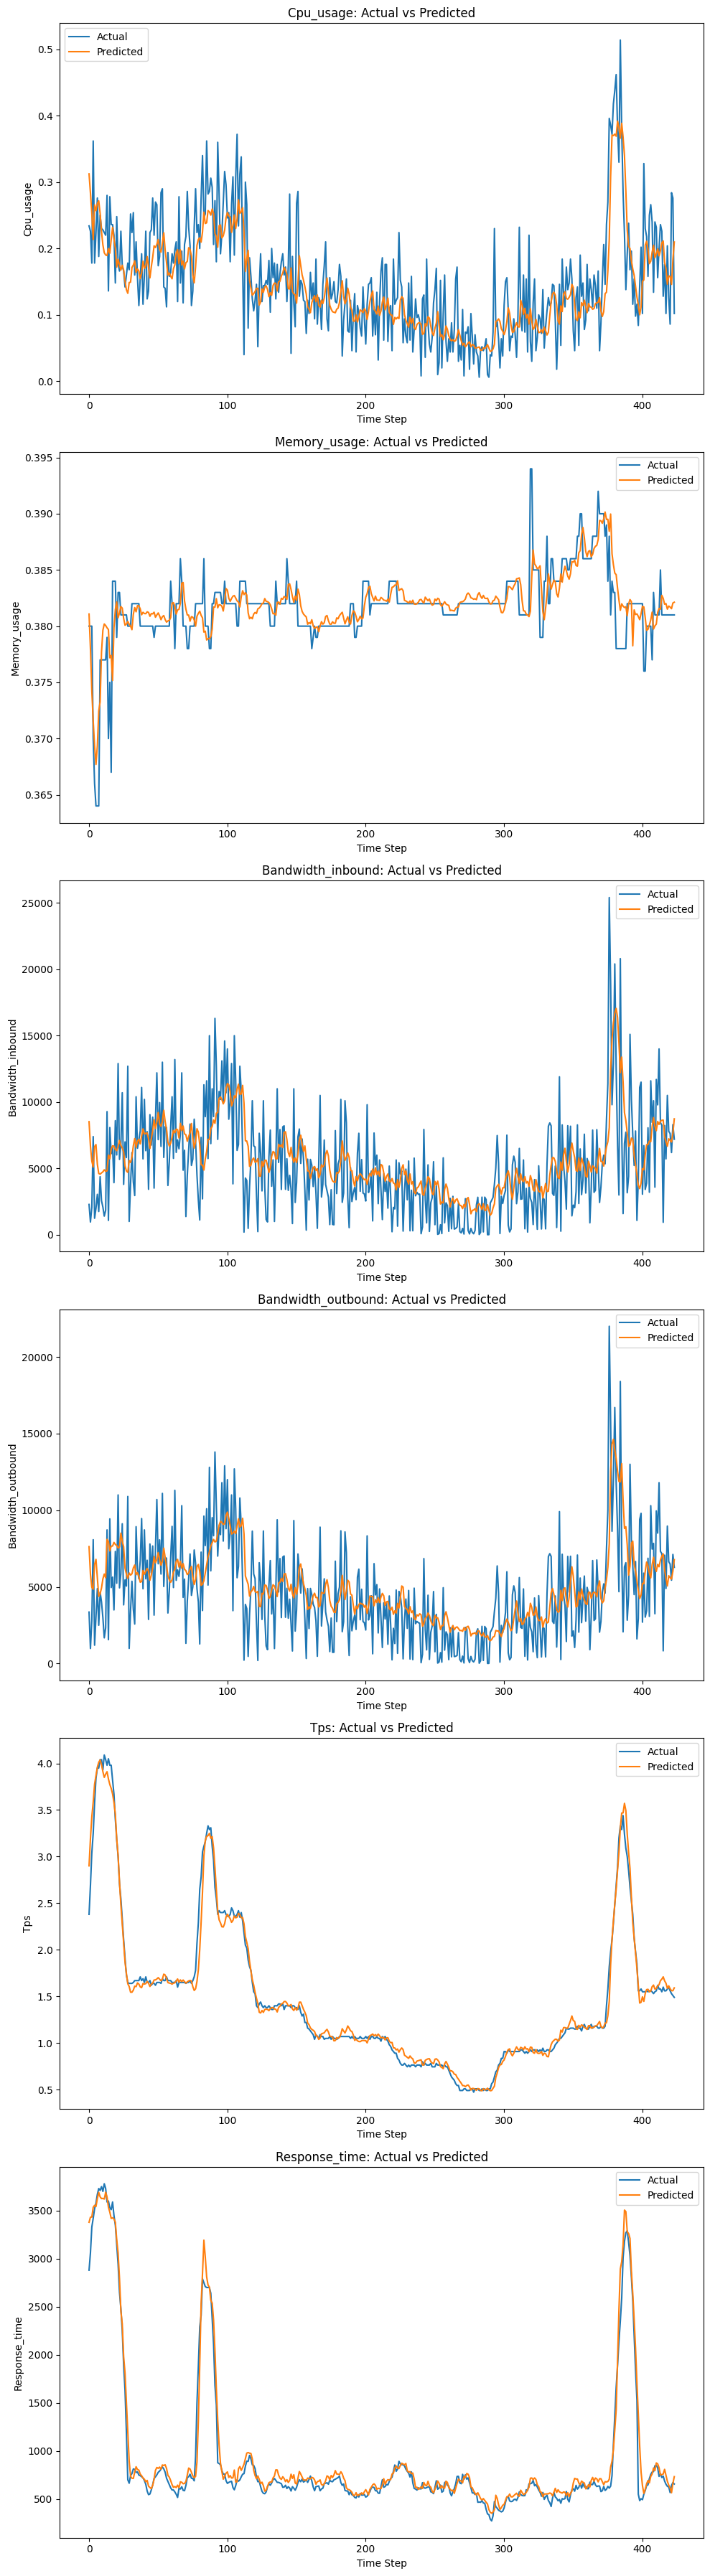

In [8]:
# Plot actual vs predicted
fig, axs = plt.subplots(len(target_columns), figsize=(10, 6*len(target_columns)))

for i, target_col in enumerate(target_columns):
    actual_val = scalers[target_col].inverse_transform(test[n_past:, i].reshape(-1,1))
    predicted_val = scalers[target_col].inverse_transform(np.array(predictions[target_col]).reshape(-1,1))
    print_score(actual_val, predicted_val, target_col)
    axs[i].plot(actual_val, label='Actual')
    axs[i].plot(predicted_val, label='Predicted')
    axs[i].set_title(f'{target_col.capitalize()}: Actual vs Predicted')
    axs[i].set_ylabel(f'{target_col.capitalize()}')
    axs[i].set_xlabel('Time Step')
    axs[i].legend()

# Show the figure with subplots
plt.tight_layout()
plt.show()

In [9]:
inverse_transform_predictions = {}

for i, target_col in enumerate(target_columns):
    inverse_transform_predictions[target_col] = scalers[target_col].inverse_transform(np.array(predictions[target_col]).reshape(-1,1)).flatten()

# Let's convert it to DataFrame to check the result
df_inverse_predictions = pd.DataFrame(inverse_transform_predictions)
np_predictions = pd.DataFrame(df_inverse_predictions.values, columns=target_columns)

print(np_predictions.head())
print(len(np_predictions))

   cpu_usage  memory_usage  bandwidth_inbound  bandwidth_outbound       tps   
0   0.312460      0.381080        8522.274414         7628.886230  2.900865  \
1   0.283625      0.378003        6684.078613         5829.199707  3.192564   
2   0.252622      0.374214        5553.866211         4977.825684  3.427404   
3   0.213506      0.371563        5103.954102         4848.253906  3.583863   
4   0.265702      0.369347        6646.811523         6462.309570  3.777953   

   response_time  
0    3378.809082  
1    3431.662842  
2    3433.141846  
3    3534.531982  
4    3555.338867  
424


### Export the model

In [10]:
pickle.dump(models, open('../../models/multivariate/lstm/models.p', 'wb'))
pickle.dump(scalers, open('../../models/multivariate/lstm/_scalers.p', 'wb'))
pickle.dump(np_predictions, open('../../models/multivariate/lstm/_predictions_result.p', 'wb'))
pickle.dump(statuses, open('../../models/multivariate/lstm/_statuses_test.p', 'wb'))